# Assignment 05

## Recommender Systems

## CSCI E-108

### Steve Elston

## Introduction

Recommender algorithms are widely used in commerce. Further, the basic algorithms have found applications in other areas. In this Assignment you gain some experience working with recommender data, the collaborative filtering algorithm and some versions of the nonnegative matrix factorization algorithm.           

This Assignment uses the Python **[Surprise](https://surprise.readthedocs.io/en/stable/index.html)** package a Scikit for recommender system experimentation. This package is in maintenance mode, but is still useful for learning recommender concepts. If you have not previously installed Surprise you will need to install it. Generally, the best way to install this older package is to run the command below from a command prompt on your system. If you have difficulty, you can refer to [this Stackoverflow thread](https://stackoverflow.com/questions/62042317/cannot-install-scikit-surprise-on-my-jupyter-notebook).      

In [1]:
#!pip install surprise

In [2]:
# !pip install --upgrade numpy  # Upgrade NumPy first
# !pip install --upgrade --no-cache-dir --force-reinstall surprise  # Reinstall Surprise

In [3]:
# Reinstall numpy and scikit-surprise to make sure versions are compatible
# !pip uninstall -y numpy
# !pip install numpy==1.23.5
# !pip install scikit-surprise --no-binary :all:

> **Computational note:** The Surprise package was never intended as a production recommender system. If you want to explore options for production scalable recommender systems some options include:   
> 1. The Neo4J graph database contains extensive support for enterprise recommendation systems. You can see a tutorial introduction [here](https://neo4j.com/developer/cypher/guide-build-a-recommendation-engine/).   
> 2. The major cloud machine learning platforms, such as Keras and PyTorch, have increasing massive scale support for recommendation algorithms. You can find some getting started information for both [Kera](https://keras.io/examples/structured_data/collaborative_filtering_movielens/) and [PyTorch](https://pytorch.org/blog/introducing-torchrec/).

Execute the code in the cell below to import the packages you will need for this assignment.

In [4]:
from surprise.prediction_algorithms.matrix_factorization import SVD, NMF
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.knns import KNNBasic
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load and Explore the Dataset   

In this Assignment you will work with the MovieLens 100k dataset. This dataset includes a total of 100,000 movie ratings from IMDB.

Before working with recommender algorithms, you will explore these data. Exploration of data is an essential step in any data mining process.     

The code in the cell below loads the dataset and splits it into training and testing datasets. Execute this code. If you are asked if you want to download the data you must answer y.

In [5]:
## Load the movielens-100k dataset
## Answer y if you are asked to download the dataset
movie_lense_data = Dataset.load_builtin('ml-100k')

## Split the dataset into training and test subsets.
np.random.seed(4517)
ml_trainset, ml_testset = train_test_split(movie_lense_data, test_size=0.20)

Before experimenting with the recommender algorithms we will explore the data. As a first step of the execute the code in the cell below to print some characteristics of the training dataset.  

In [6]:
print('For training dataset:')
print("Number of users = {}".format(ml_trainset.n_users))
print("Number of items = {}".format(ml_trainset.n_items))
print("Number of ratings = {}".format(ml_trainset.n_ratings))

For training dataset:
Number of users = 943
Number of items = 1654
Number of ratings = 80000


You can see some basic characteristics of the training dataset. If these data were represented as a rectangular table or matrix they would require, over 1.5 million, and at least that many bytes. In practice, a more efficient representation is used.

The Surprise package, like all real-world recommender software, uses a space efficient representation. The `ur` attribute of the Surprise data object contains a dictionary with the recommender data. The keys of the dictionary are numeric identifiers of the users. The values of this key-value pairs are a list of tuples. The tuples are key-value pairs, with the key being the item identifier and the rating. In summary, there is a hashed user key to item key-value pairs. This nesting of key-value pairs is necessary since Python dictionaries only support a single hashed key per value.        

The code in the cell below prints the list of key-value pairs for a single user key. There are multiple item identifier, rating, tupples for user 5. Execute this code and examine the results.   

In [7]:
## Print the product-rating tupples in the 'ur' attribute of the data object from user 6
print(f"The number of recommendations = {len(ml_trainset.ur[5])}")
ml_trainset.ur[5]

The number of recommendations = 32


[(5, 4.0),
 (339, 4.0),
 (919, 5.0),
 (169, 4.0),
 (574, 2.0),
 (49, 2.0),
 (563, 2.0),
 (144, 5.0),
 (859, 3.0),
 (650, 1.0),
 (4, 4.0),
 (507, 3.0),
 (75, 2.0),
 (289, 2.0),
 (593, 4.0),
 (348, 2.0),
 (160, 4.0),
 (47, 5.0),
 (34, 3.0),
 (904, 2.0),
 (216, 3.0),
 (407, 3.0),
 (322, 2.0),
 (477, 1.0),
 (349, 3.0),
 (557, 4.0),
 (321, 3.0),
 (372, 3.0),
 (955, 2.0),
 (276, 5.0),
 (1069, 4.0),
 (616, 4.0)]

User 5 has only rated 32 items of 1647 total items.     

> **Exercise 05-1:** To gain some understanding of the nature of the ratings, in the cell below create and execute code to compute and print two summary statistics in decimal fraction format. Use the attributes of the training dataset to extract the required parameters. See the foregoing example for an example of accessing the attributes of the data object.        
> 1. Fraction of all items rated by user 5.
> 2. The fraction of possible item-user pairs in the utility matrix that have non-null values.        
> **Hint:** Keep in mind that we are using a dictionary as the data struvture here. Dictionaries are based on key-value pairs. Therefore, the key for any user is their user ID, and the values are the ratings for that user.  

In [8]:
user_5_ratings = len(ml_trainset.ur[5])
total_items = ml_trainset.n_items
fraction_items_rated_by_user_5 = user_5_ratings / total_items

total_ratings = ml_trainset.n_ratings
total_possible_pairs = ml_trainset.n_users * ml_trainset.n_items
fraction_non_null_pairs = total_ratings / total_possible_pairs

print(f"Fraction of items rated by user 5: {fraction_items_rated_by_user_5:.4f}")
print(f"Fraction of non-null user-item pairs: {fraction_non_null_pairs:.4f}")

Fraction of items rated by user 5: 0.0193
Fraction of non-null user-item pairs: 0.0513


> Q1. Given that real-world online catalog (products, videos, music, etc.) can contain millions of items, do you think these fractions for an individual user and the average user are realistic or too high?

> **Answer:** The fractions look realistic in the real-world system as real-world catalogs are large and it is normal for overall sparsitt in the recommender system.   

> 3. Create two lists with the following values, a) list named `mean_ratings` containing the mean rating of each user, and b) a list named `number_ratings` that contains the count of ratings for each user. The user ratings are represented with a Python dictionary, with the user identifier as key, in the `ur` attribute of the training dataset. You can extract the keys (user identifiers) with the `keys` method.  
> 4. Once you have completed your code, execute the code in the cell below to display the histograms.  

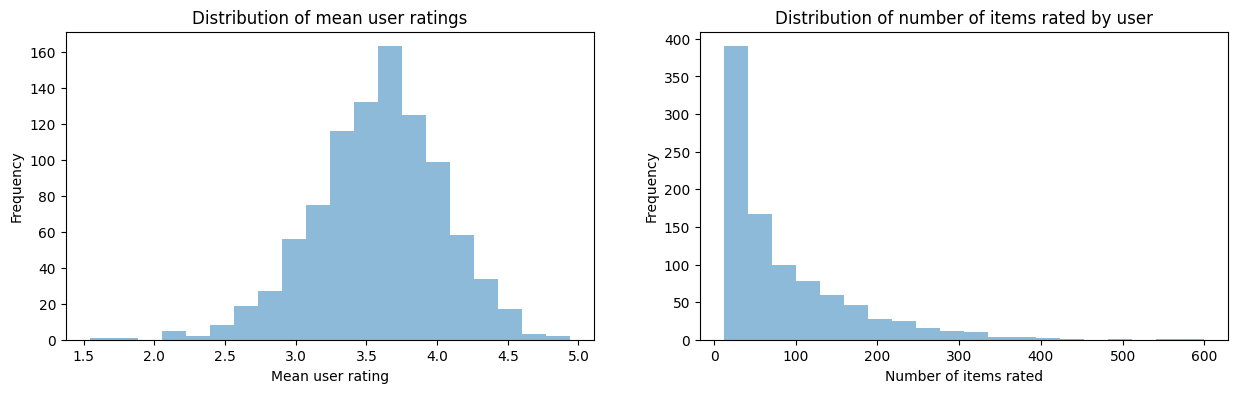

In [9]:
## Compute the mean rating for each of the users in the training dataset

mean_ratings = []
number_ratings = []

for user_id in ml_trainset.ur.keys():
    user_ratings = [rating for (_, rating) in ml_trainset.ur[user_id]]
    number_ratings.append(len(user_ratings))
    mean_ratings.append(np.mean(user_ratings))

## Create a histograms of the results
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(mean_ratings, bins=20, alpha=0.5)
_=ax[0].set_xlabel('Mean user rating')
_=ax[0].set_ylabel('Frequency')
_=ax[0].set_title('Distribution of mean user ratings')
_=ax[1].hist(number_ratings, bins=20, alpha=0.5)
_=ax[1].set_xlabel('Number of items rated')
_=ax[1].set_ylabel('Frequency')
_=ax[1].set_title('Distribution of number of items rated by user')

> Provide short answers to the following questions:   
> Q2. Is the distribution of the mean user ratings a bit skewed? What does this skew tell us?   
> Q3. Notice the rapid decay in the frequency of items rated by users. What does this long tail tell you about user behavior?  
> **End of exercise.**

> **Answers:**   
> Q2. Yes the distribution is slightly negative skewed that means the customers tend to rate the movies high. It also says that the customers are more likely to rate the movies they like.       
> Q3. The long tail indicates the majority of users rate only a small number of items, but a few users rate a lot.

## Baseline Only Model

One possible answer to the cold start problem is to use a **baseline only** model. In this model we just use the average or baseline values for users or items to predict ratings. This same approach can be applied to users who consume an item, but provide no rating.

> **Exercise 05-2:** You will now create and evaluate a baseline recommender model. Do the following:   
> 1. Instantiate a [surprise.prediction_algorithms.baseline_only.BaselineOnly](https://surprise.readthedocs.io/en/stable/basic_algorithms.html) model object and it with the `fit` method using the `ml_trainset` as the argument. Name your model object `baseline_model`.  
> 2. Compute the recommender predictions with the `test` method using the `ml_testset` as the argument.   
> 3. Compute and print the RMSE using [surprise.accuracy.rmse](https://surprise.readthedocs.io/en/stable/accuracy.html) and MAE using [surprise.accuracy.mae](https://surprise.readthedocs.io/en/stable/accuracy.html) with the predictions as the argument in both cases.  

In [10]:
np.random.seed(864)
## Instantiate the model object and fit to the training data

baseline_model = BaselineOnly()
baseline_model.fit(ml_trainset)

## Compute the predicitons from the model
predictions = baseline_model.test(ml_testset)

# Compute some model performance statistics

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Estimating biases using als...
RMSE: 0.9371
MAE:  0.7421
RMSE: 0.9371
MAE: 0.7421


> Q1. Does the accuracy performance of this model seem good given its simplicity?   

> **Answer:** Yes, the performance is pretty good considering the model's simplicity. RMSE is .9371 and MAE is .7421 saying the predictions are reasonably close to the actual ratings.    

> 4. Execute the code in the cell below to display histograms of the item and user biases.

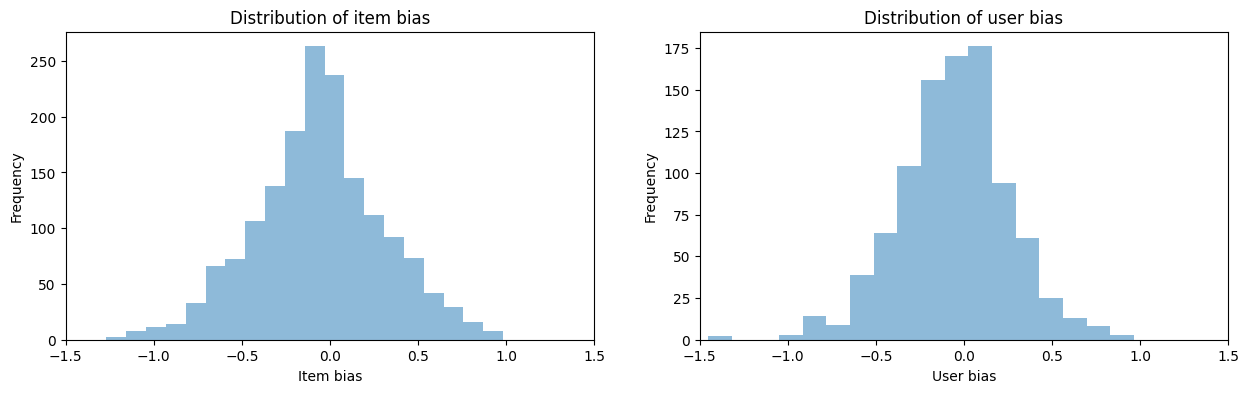

In [11]:
## plot the biases
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(baseline_model.bi, bins=20, alpha=0.5)
_=ax[0].set_xlabel('Item bias')
_=ax[0].set_ylabel('Frequency')
_=ax[0].set_title('Distribution of item bias')
_=ax[0].set_xlim(-1.5,1.5)
_=ax[1].hist(baseline_model.bu, bins=20, alpha=0.5)
_=ax[1].set_xlabel('User bias')
_=ax[1].set_ylabel('Frequency')
_=ax[1].set_title('Distribution of user bias')
_=ax[1].set_xlim(-1.5,1.5)

> Q2. These bias values are approximately Normally distributed, but with somewhat heavy tails. Examine the range of these biases. What does the fact that these ranges are small compared to the range of ratings tell you about the magnitude of the bias adjustments?      

> **Answer:** The values of bias for both customers and items range from -1.5 to +1.5 while the actual rating in the dataset range from 1 to 5, that is saying the bias adjustmets are relatively small.    

> 5. Ideally, the biases should be uniformly distributed with identifier. In other words, statistically independent of the identifiers. In other words, **homoskedastic**. Execute the code to display the relationship.

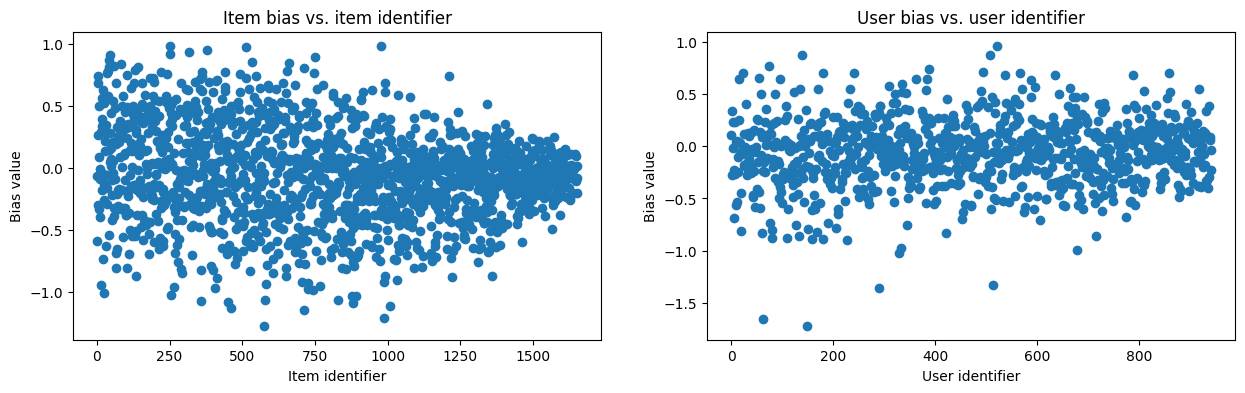

In [12]:
## plot the biases
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].scatter(range(len(baseline_model.bi)), baseline_model.bi)
_=ax[0].set_xlabel('Item identifier')
_=ax[0].set_ylabel('Bias value')
_=ax[0].set_title('Item bias vs. item identifier')
_=ax[1].scatter(range(len(baseline_model.bu)), baseline_model.bu)
_=ax[1].set_xlabel('User identifier')
_=ax[1].set_ylabel('Bias value')
_=ax[1].set_title('User bias vs. user identifier')

> Q3. Does the distribution of the biases look largely uniform with item identifier or not?    
> Q4. Does the distribution of the biases look largely uniform with user identifier or not?   

> **Answers:**   
> Q3. Yes, the item biases llok to be largely uniform across the item identifiers.      
> Q4. Yes, the user biases also look to be largely uniform across user identifiers.    

## Collaborative Filtering Model  

The collaborative filtering model is an unsupervised learning model using similarity item-item or user-user similarity measures. Items with the highest similarity measures are recommended.  

> **Exercise 05-3:** You will now create and evaluate a baseline recommender model. Do the following:   
> 1. Instantiate a [surprise.prediction_algorithms.knns.KNNBasic](https://surprise.readthedocs.io/en/stable/knn_inspired.html) model object and it with the `fit` method using the `ml_trainset` as the argument. Name your model object `collaborative_filter_model`.  
> 2. Compute the recommender predictions with the `test` method using the `ml_testset` as the argument.   
> 3. Compute and print the RMSE using `surprise.accuracy.rmse and MAE using `surprise.accuracy.mae` with the predictions as the argument in both cases.  

In [13]:
np.random.seed(258)
## Instantiate the model object and fit to the training data

collaborative_filter_model = KNNBasic()
collaborative_filter_model.fit(ml_trainset)
## Compute the predicitons from the model

predictions = collaborative_filter_model.test(ml_testset)
# Compute some model performance statistics

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9676
MAE:  0.7636
RMSE: 0.9676
MAE: 0.7636


> Provide short answers to the following questions:     
> Q1. Compare the performance of this model to the baseline model. Is it better or worse?     
> Q2. Keeping in mind that the rating sampling is more dense that a real-world example, what does this tell you about the effectiveness of a baseline model vs. the model based on similarity.    
  

> **Answers:**       
> Q1. The baseline model performed better as it achieved lower error on RMSE and MAE.          
> Q2. As this dataset is kind of dense comparing to the real-world data, the base-line model, i.e., bias-based model, performs pretty well.    

> 4. The distribution of the similarities gives insight into the behavior of the model. Execute the code in the to display the histogram of the user-user similarity measures.   

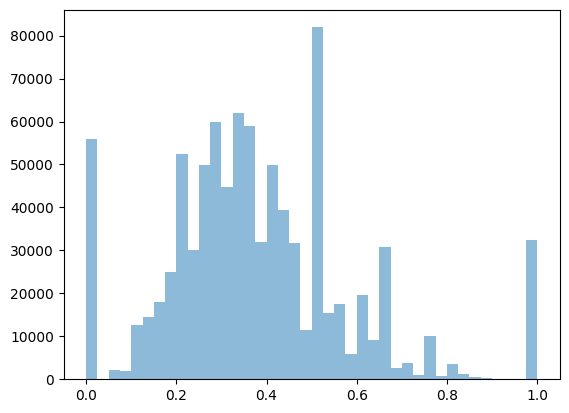

In [14]:
_=plt.hist(collaborative_filter_model.sim.flatten(), bins=40, alpha=0.5)

> Q3. Examine the plot. Notice there are a number of similarities which are or are close to 0 or 1, and another spike around 0.5. Is the distribution of these similarities skewed? If so, what does this skew tell you about how strong a predictor similarity can be in this case.    
> **End of exercise.**

> **Answer:** Yes, the distribution of smiliarities is clearly skewed. The sharp spikes are around 0, 0.5 and 1. This tells us the similarity is a weak or noisy signal for most pairs here.         

## Matrix Factorization Methods   

Matrix factorization algorithms are generally considered to be the state of the art for recommenders. The matrix factorization methods find a set of latent (non-observable) factor variable values, which are used to compute rating estimates. Additionally, user and item rating bias adjustments are applied.    

> **Exercise 05-4:** You will now create and evaluate a baseline recommender model. Do the following:   
> 1. Instantiate a [surprise.prediction_algorithms.matrix_factorization.SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html) model object, using 10 factors, and it with the `fit` method using the `ml_trainset` as the argument. Name your model object `svd_model`.  
> 2. Compute the recommender predictions with the `test` method using the `ml_testset` as the argument.   
> 3. Compute and print the RMSE using `surprise.accuracy.rmse` and MAE using `surprise.accuracy.mae` with the predictions as the argument in both cases.  

In [15]:
np.random.seed(9741)
## Instantiate the model object and fit to the training data

svd_model = SVD(n_factors=10)
svd_model.fit(ml_trainset)
## Compute the predicitons from the model

predictions = svd_model.test(ml_testset)
# Compute some model performance statistics

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.9304
MAE:  0.7337
RMSE: 0.9304
MAE: 0.7337


> Provide short answers to the following questions:   
> Q1. Compare the performance of this model to the baseline model. Is it better or worse?     
> Q2. Keeping in mind that the rating sampling is more dense that a real-world example, what does this tell you about the effectiveness of a baseline model vs. the model based on latent factors.    


> **Answers:**       
> Q1. SVD model performs a little bit better than baseline model as both RMSE and MAE are lower comparatively.       
> Q2. Even in the dense dataset like MovieLens, the SVD model performs a little bit better than the baseline one.    

> 4. The distribution of the item and factor values gives insight into the behavior of the model. Execute the code in the to display the histograms of the factors for items and users.     

Shape of item factor matrix: (1654, 10)
Shape of user factor matrix: (943, 10)


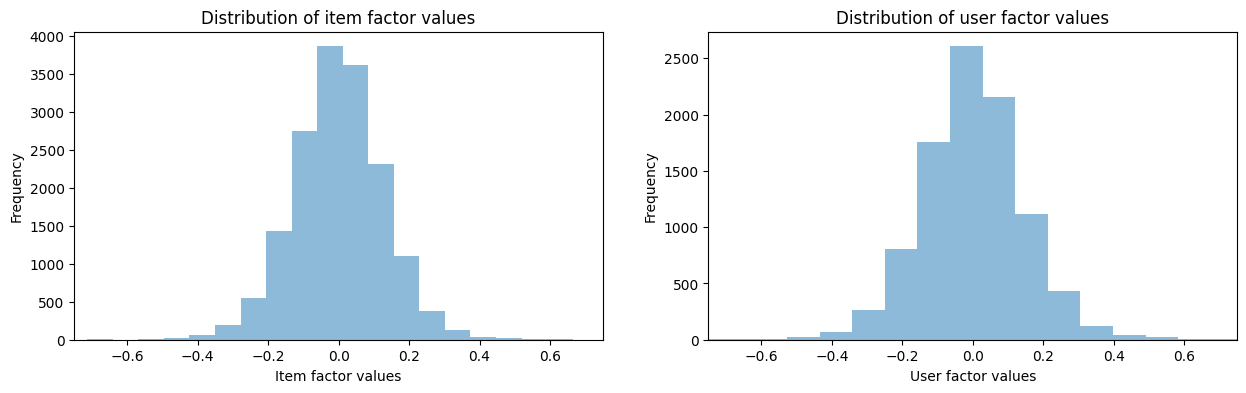

In [16]:
print('Shape of item factor matrix: {}'.format(svd_model.qi.shape))
print('Shape of user factor matrix: {}'.format(svd_model.pu.shape))

## Create a histograms of the factor values
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(svd_model.qi.flatten(), bins=20, alpha=0.5)
_=ax[0].set_xlabel('Item factor values')
_=ax[0].set_ylabel('Frequency')
_=ax[0].set_title('Distribution of item factor values')
_=ax[0].set_xlim(-.75,.75)
_=ax[1].hist(svd_model.pu.flatten(), bins=20, alpha=0.5)
_=ax[1].set_xlabel('User factor values')
_=ax[1].set_ylabel('Frequency')
_=ax[1].set_title('Distribution of user factor values')
_=ax[1].set_xlim(-.75,.75)

> 5. Finally, you will compute the compression of the factor model compared to a model using the full utility matrix.

In [17]:
## Calculation of compression of factor model
n_reviews = 0
for key in ml_trainset.ur.keys():
    n_reviews += len(ml_trainset.ur[key])
print(f"Total number of reviews = {n_reviews}")
utility_bytes = 8*n_reviews + 4*ml_trainset.n_users
print(f"Bytes for all review tuples = {utility_bytes}")

n_factors = 10

P_size = n_factors * ml_trainset.n_users
Q_size = n_factors * ml_trainset.n_items
print(f"Values in P = {P_size}")
print(f"Values in Q = {Q_size}")
PQ_bytes = 4 * (P_size + Q_size)
print(f"Total bytes for P + Q = {PQ_bytes}")

Total number of reviews = 80000
Bytes for all review tuples = 643772
Values in P = 9430
Values in Q = 16540
Total bytes for P + Q = 103880


> Provide short answers to the following questions:     
> Q3. Examine the distribution of the factor values. Compare these values to the distribution of baseline or bias values for the Baseline model. What do the differences in the range of values tell you about the effect of subtracting the bias terms before computing the factor values?     
> Q4. Notice the dimensions of factor matrices computed, Q, P. Is this representation compact compared to the original data set, and why?     
> **End of exercise.**

> **Answers:**   
> Q3. The factor values in matrix factorization P and Q span a wider and more variable range than the bias values. The bias terms capture smple global tendencies, and factor terms model subtle user-item interactions beyond bias.    
> Q4. Yes, the factorized representation is extremely compact. This is because the factor model only stores latent features, which helps make the representation compact.

#### Copyright 2021, 2022, 2023, 2025, Stephen F Elston. All rights reserved.